In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Paths and config
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()),'dataset', 'training_dataset', 'new_queues_concurrency_4_after_migration', 'preprocessed_data.csv')
TARGET = 'pipelines_status_realtime_pipeline_latency'
H = 10  # prediction horizons (1..H steps ahead)
TEST_SIZE = 0.2  # temporal split proportion for test
VAL_SIZE = 0.1   # temporal split proportion from train
LAGS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # create 10-step autoregressive lags


In [2]:
df=pd.read_csv(DATA_PATH)
df.head()

,date,cluster,pipelines_status_avg_fps,pipelines_status_avg_pipeline_latency,node_cpu_usage,node_mem_usage,pipelines_server_cpu_usage,pipelines_server_mem_usage,number_pipelines,pipelines_status_realtime_pipeline_latency
0,2025-07-29 09:01:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.352188,0.090613,2.809000,1.704713e+10,2.510287,2.280022e+09,2,0.059788
1,2025-07-29 09:01:30,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.165781,0.081213,6.491000,1.693688e+10,4.985779,2.290201e+09,2,0.069696
2,2025-07-29 09:02:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.091167,0.079892,6.263667,1.715416e+10,4.987372,2.289852e+09,2,0.080496
3,2025-07-29 09:02:30,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.058757,0.077550,6.390667,1.723684e+10,4.986633,2.287923e+09,2,0.054376
4,2025-07-29 09:03:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.036760,0.082188,6.353333,1.717032e+10,5.050752,2.292724e+09,2,0.042890


<Axes: >

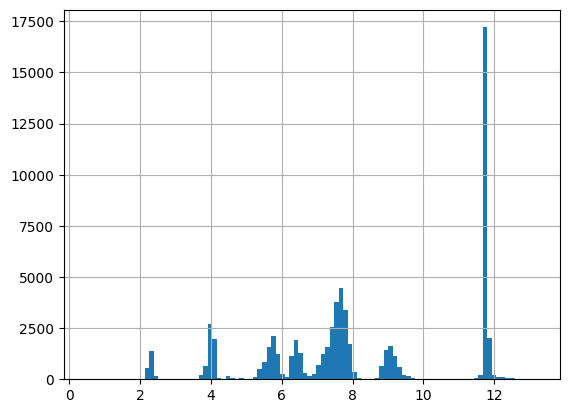

In [3]:
df.node_cpu_usage.hist(bins=100)

<Axes: >

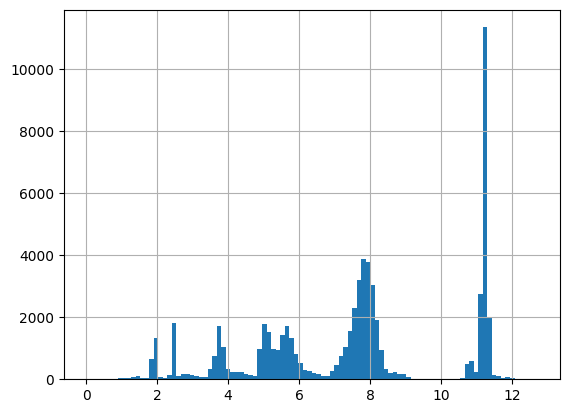

In [4]:
df.pipelines_server_cpu_usage.hist(bins=100)

In [5]:
print(df.columns, "\n")
print(len(df),"\n")
print(df.dtypes)


Index(['date', 'cluster', 'pipelines_status_avg_fps',
       'pipelines_status_avg_pipeline_latency', 'node_cpu_usage',
       'node_mem_usage', 'pipelines_server_cpu_usage',
       'pipelines_server_mem_usage', 'number_pipelines',
       'pipelines_status_realtime_pipeline_latency'],
      dtype='object') 

66181 

date                                           object
cluster                                        object
pipelines_status_avg_fps                      float64
pipelines_status_avg_pipeline_latency         float64
node_cpu_usage                                float64
node_mem_usage                                float64
pipelines_server_cpu_usage                    float64
pipelines_server_mem_usage                    float64
number_pipelines                                int64
pipelines_status_realtime_pipeline_latency    float64
dtype: object


In [6]:
df['date'] = pd.to_datetime(df['date'])
# Time encodings
df['minute'] = df['date'].dt.minute
# 15-min quarter bucket: 0..3
df['quarter_15m'] = (df['minute'] // 15).astype(int)
df['hour'] = df['date'].dt.hour
# Day-of-month 1..31
# df['day'] = df['date'].dt.day
# Monday=0..Sunday=6
# df['weekday'] = df['date'].dt.weekday
# ISO week number 1..53
iso = df['date'].dt.isocalendar()
# df['week'] = iso.week.astype(int)
# Month 1..12
# df['month'] = df['date'].dt.month
df[TARGET]=df.pop(TARGET)


In [7]:
df.head()


,date,cluster,pipelines_status_avg_fps,pipelines_status_avg_pipeline_latency,node_cpu_usage,node_mem_usage,pipelines_server_cpu_usage,pipelines_server_mem_usage,number_pipelines,minute,quarter_15m,hour,pipelines_status_realtime_pipeline_latency
0,2025-07-29 09:01:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.352188,0.090613,2.809000,1.704713e+10,2.510287,2.280022e+09,2,1,0,9,0.059788
1,2025-07-29 09:01:30,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.165781,0.081213,6.491000,1.693688e+10,4.985779,2.290201e+09,2,1,0,9,0.069696
2,2025-07-29 09:02:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.091167,0.079892,6.263667,1.715416e+10,4.987372,2.289852e+09,2,2,0,9,0.080496
3,2025-07-29 09:02:30,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.058757,0.077550,6.390667,1.723684e+10,4.986633,2.287923e+09,2,2,0,9,0.054376
4,2025-07-29 09:03:00,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,15.036760,0.082188,6.353333,1.717032e+10,5.050752,2.292724e+09,2,3,0,9,0.042890


<Axes: >

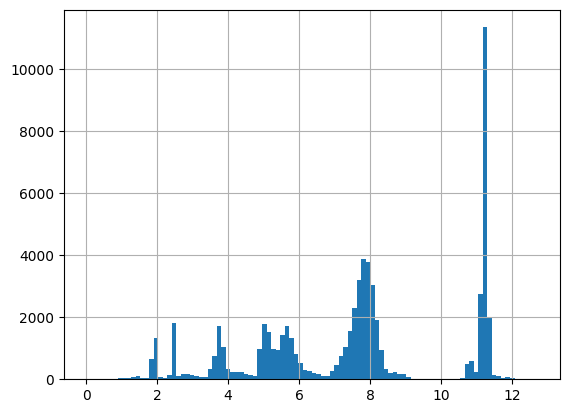

In [8]:
df.pipelines_server_cpu_usage.hist(bins=100)

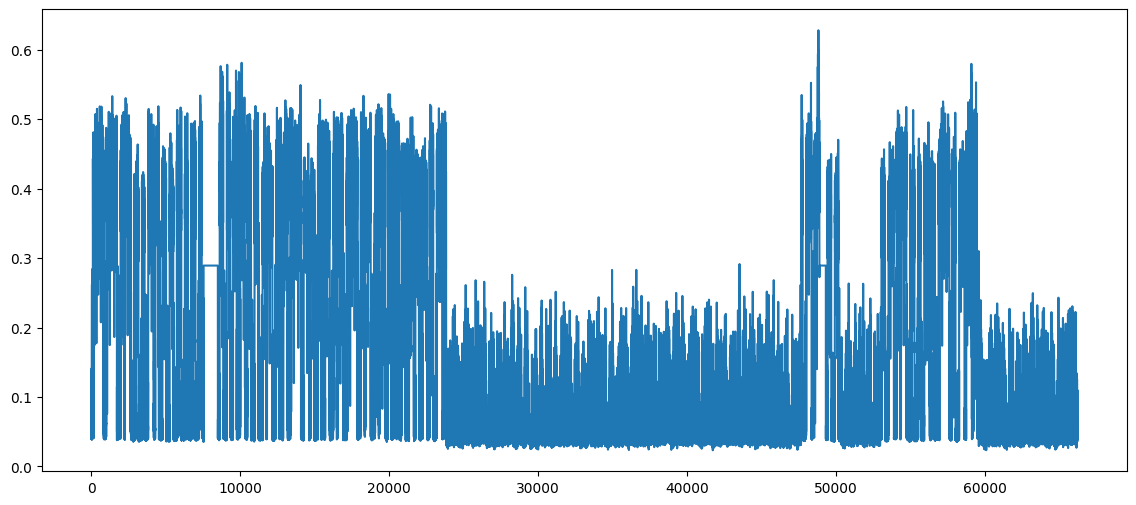

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df[TARGET])
plt.show()

In [10]:
w = 10
n = (len(df) // w) * w
g = np.arange(n) // w

num_cols = df.select_dtypes(include=np.number).columns
df_windows = df.iloc[:n].groupby(g).agg({
    **{c: 'mean' for c in num_cols},
    'cluster': 'last'  # or 'last'
})
df_windows.index = df.index[:n:w]
non_num = df.columns.difference(num_cols)
agg = {**{c: 'mean' for c in num_cols}, **{c: 'last' for c in non_num}}
df_windows = df.iloc[:n].groupby(g).agg(agg)
df_windows.index = df.index[:n:w]

In [11]:
df_windows

,pipelines_status_avg_fps,pipelines_status_avg_pipeline_latency,node_cpu_usage,node_mem_usage,pipelines_server_cpu_usage,pipelines_server_mem_usage,number_pipelines,minute,quarter_15m,hour,pipelines_status_realtime_pipeline_latency,cluster,date
0,15.090994,0.083243,6.036433,1.714037e+10,4.768147,2.288597e+09,2.0,3.0,0.0,9.0,0.057393,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:05:30
10,15.019418,0.086806,6.488267,1.720025e+10,5.138889,2.289157e+09,2.0,8.0,0.0,9.0,0.064287,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:10:30
20,15.011365,0.089988,6.411033,1.710693e+10,5.042925,2.288631e+09,2.0,13.0,0.2,9.0,0.056161,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:15:30
30,15.008161,0.088683,6.465767,1.727254e+10,4.864561,2.288830e+09,2.0,18.0,1.0,9.0,0.063861,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:20:30
40,15.006837,0.089954,6.437332,1.723279e+10,4.640629,2.290048e+09,2.0,23.0,1.0,9.0,0.069371,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:25:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66130,15.006812,0.091142,5.864500,8.391442e+09,5.535275,2.194507e+09,3.0,36.0,2.0,16.0,0.052384,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:38:30
66140,15.005032,0.092042,5.793733,8.344100e+09,5.713250,2.177150e+09,3.0,41.0,2.0,16.0,0.058375,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:43:30
66150,15.003889,0.092094,5.788200,8.349549e+09,5.503680,2.176724e+09,3.0,46.0,2.8,16.0,0.053662,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:48:30
66160,15.002956,0.091381,5.718633,8.329187e+09,5.447582,2.175594e+09,3.0,51.0,3.0,16.0,0.043525,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:53:30


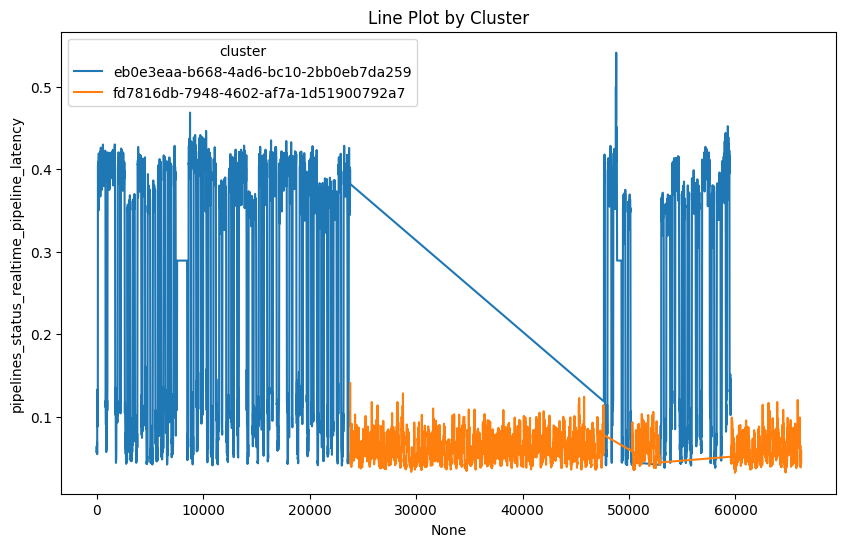

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_windows, x=df_windows.index, y=TARGET, hue='cluster')
plt.title('Line Plot by Cluster')
plt.show()

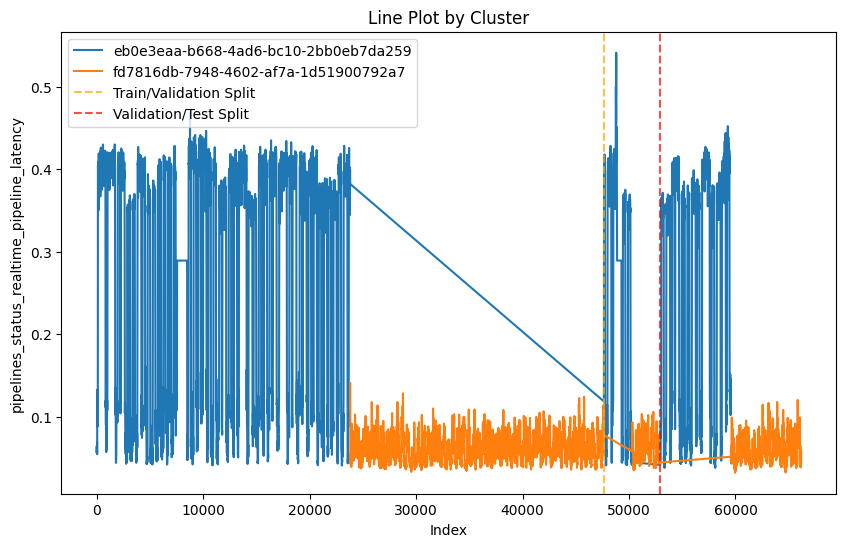

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_windows, x=df_windows.index, y=TARGET, hue='cluster')

# Calculate the positions for vertical lines
total_length = len(df)
train_val_split = int(0.72 * total_length)  # End of training data
val_test_split = int(0.8 * total_length)   # Start of test data

# Add vertical lines
plt.axvline(x=train_val_split, color='orange', linestyle='--', 
            label='Train/Validation Split', alpha=0.7)
plt.axvline(x=val_test_split, color='red', linestyle='--', 
            label='Validation/Test Split', alpha=0.7)

plt.title('Line Plot by Cluster')
plt.xlabel('Index')
plt.ylabel(TARGET)
plt.legend()
plt.show()

# Train, val, test split

In [14]:
total_length = len(df)
train_val_split = int(0.72 * total_length)  # End of training data
val_test_split = int(0.8 * total_length)    # Start of test data

# Create the splits
train_data = df[:train_val_split]
validation_data = df[train_val_split:val_test_split]
test_data = df[val_test_split:]

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (47650, 13)
Validation data shape: (5294, 13)
Test data shape: (13237, 13)


# Fit scaler and onehotencoder.

In [15]:
print(df.dtypes)
df.cluster=df.cluster.astype("category")

date                                          datetime64[ns]
cluster                                               object
pipelines_status_avg_fps                             float64
pipelines_status_avg_pipeline_latency                float64
node_cpu_usage                                       float64
node_mem_usage                                       float64
pipelines_server_cpu_usage                           float64
pipelines_server_mem_usage                           float64
number_pipelines                                       int64
minute                                                 int64
quarter_15m                                            int64
hour                                                   int64
pipelines_status_realtime_pipeline_latency           float64
dtype: object


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Dynamically identify features
all_features = train_data.columns.tolist()
exclude_columns = ['cluster', 'date', TARGET]  # TARGET is your target variable
numerical_features = [col for col in all_features if col not in exclude_columns]
categorical_features = ['cluster']

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
    ]
)

# Separate features and target (excluding date column)
features_to_keep = numerical_features + categorical_features
X_train = train_data[features_to_keep]
X_val = validation_data[features_to_keep]
X_test = test_data[features_to_keep]

y_train = train_data[TARGET]
y_val = validation_data[TARGET]
y_test = test_data[TARGET]

# Fit on training data and transform all splits
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"Original training shape: {X_train.shape}")
print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed validation shape: {X_val_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")

Numerical features: ['pipelines_status_avg_fps', 'pipelines_status_avg_pipeline_latency', 'node_cpu_usage', 'node_mem_usage', 'pipelines_server_cpu_usage', 'pipelines_server_mem_usage', 'number_pipelines', 'minute', 'quarter_15m', 'hour']
Categorical features: ['cluster']
Original training shape: (47650, 11)
Processed training shape: (47650, 11)
Processed validation shape: (5294, 11)
Processed test shape: (13237, 11)


# Keep feature names

In [17]:
# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Convert back to DataFrame if needed
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names, index=X_val.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

In [18]:
X_train_df

,num__pipelines_status_avg_fps,num__pipelines_status_avg_pipeline_latency,num__node_cpu_usage,num__node_mem_usage,num__pipelines_server_cpu_usage,num__pipelines_server_mem_usage,num__number_pipelines,num__minute,num__quarter_15m,num__hour,cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7
0,0.405120,-0.793041,-1.967056,0.879585,-1.799544,-0.128817,-1.457997,-1.641476,-1.337465,-1.521520,0.0
1,0.300600,-0.861054,-0.631783,0.856479,-0.912760,-0.114589,-1.457997,-1.641476,-1.337465,-1.521520,0.0
2,0.258763,-0.870613,-0.714225,0.902017,-0.912190,-0.115076,-1.457997,-1.583759,-1.337465,-1.521520,0.0
3,0.240590,-0.887556,-0.668169,0.919345,-0.912455,-0.117772,-1.457997,-1.583759,-1.337465,-1.521520,0.0
4,0.228256,-0.853998,-0.681708,0.905402,-0.889486,-0.111062,-1.457997,-1.526042,-1.337465,-1.521520,0.0
...,...,...,...,...,...,...,...,...,...,...,...
47645,0.214329,-0.682099,-0.183066,-0.947874,0.160668,-0.122576,0.706457,-1.179742,-1.337465,-0.641885,1.0
47646,0.213763,-0.679840,-0.183912,-0.949674,0.118229,-0.125490,0.706457,-1.122026,-1.337465,-0.641885,1.0
47647,0.212504,-0.681615,-0.241332,-0.943268,0.071035,-0.124128,0.706457,-1.122026,-1.337465,-0.641885,1.0
47648,0.002820,1.530817,1.300771,0.968946,0.269410,0.432592,0.706457,-1.006592,-1.337465,-0.641885,0.0


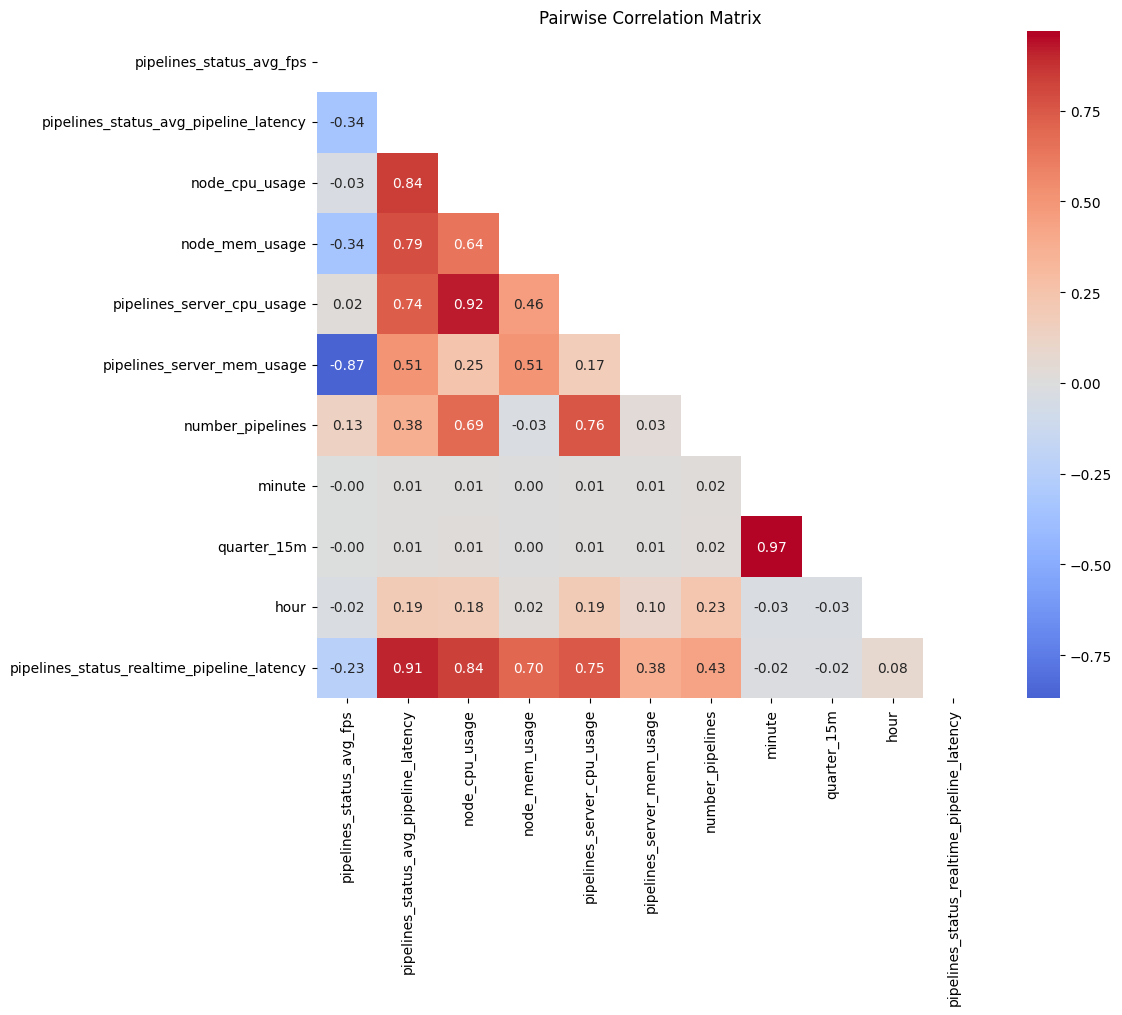

In [19]:
# Use the original training data (before scaling) for better interpretability
# Include numerical features + target
correlation_data = train_data[numerical_features + [TARGET]]
correlation_matrix = correlation_data.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Hide upper triangle
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm', 
            center=0,
            square=True,
            mask=mask,  # Show only lower triangle
            fmt='.2f')
plt.title('Pairwise Correlation Matrix')
plt.tight_layout()
plt.show()

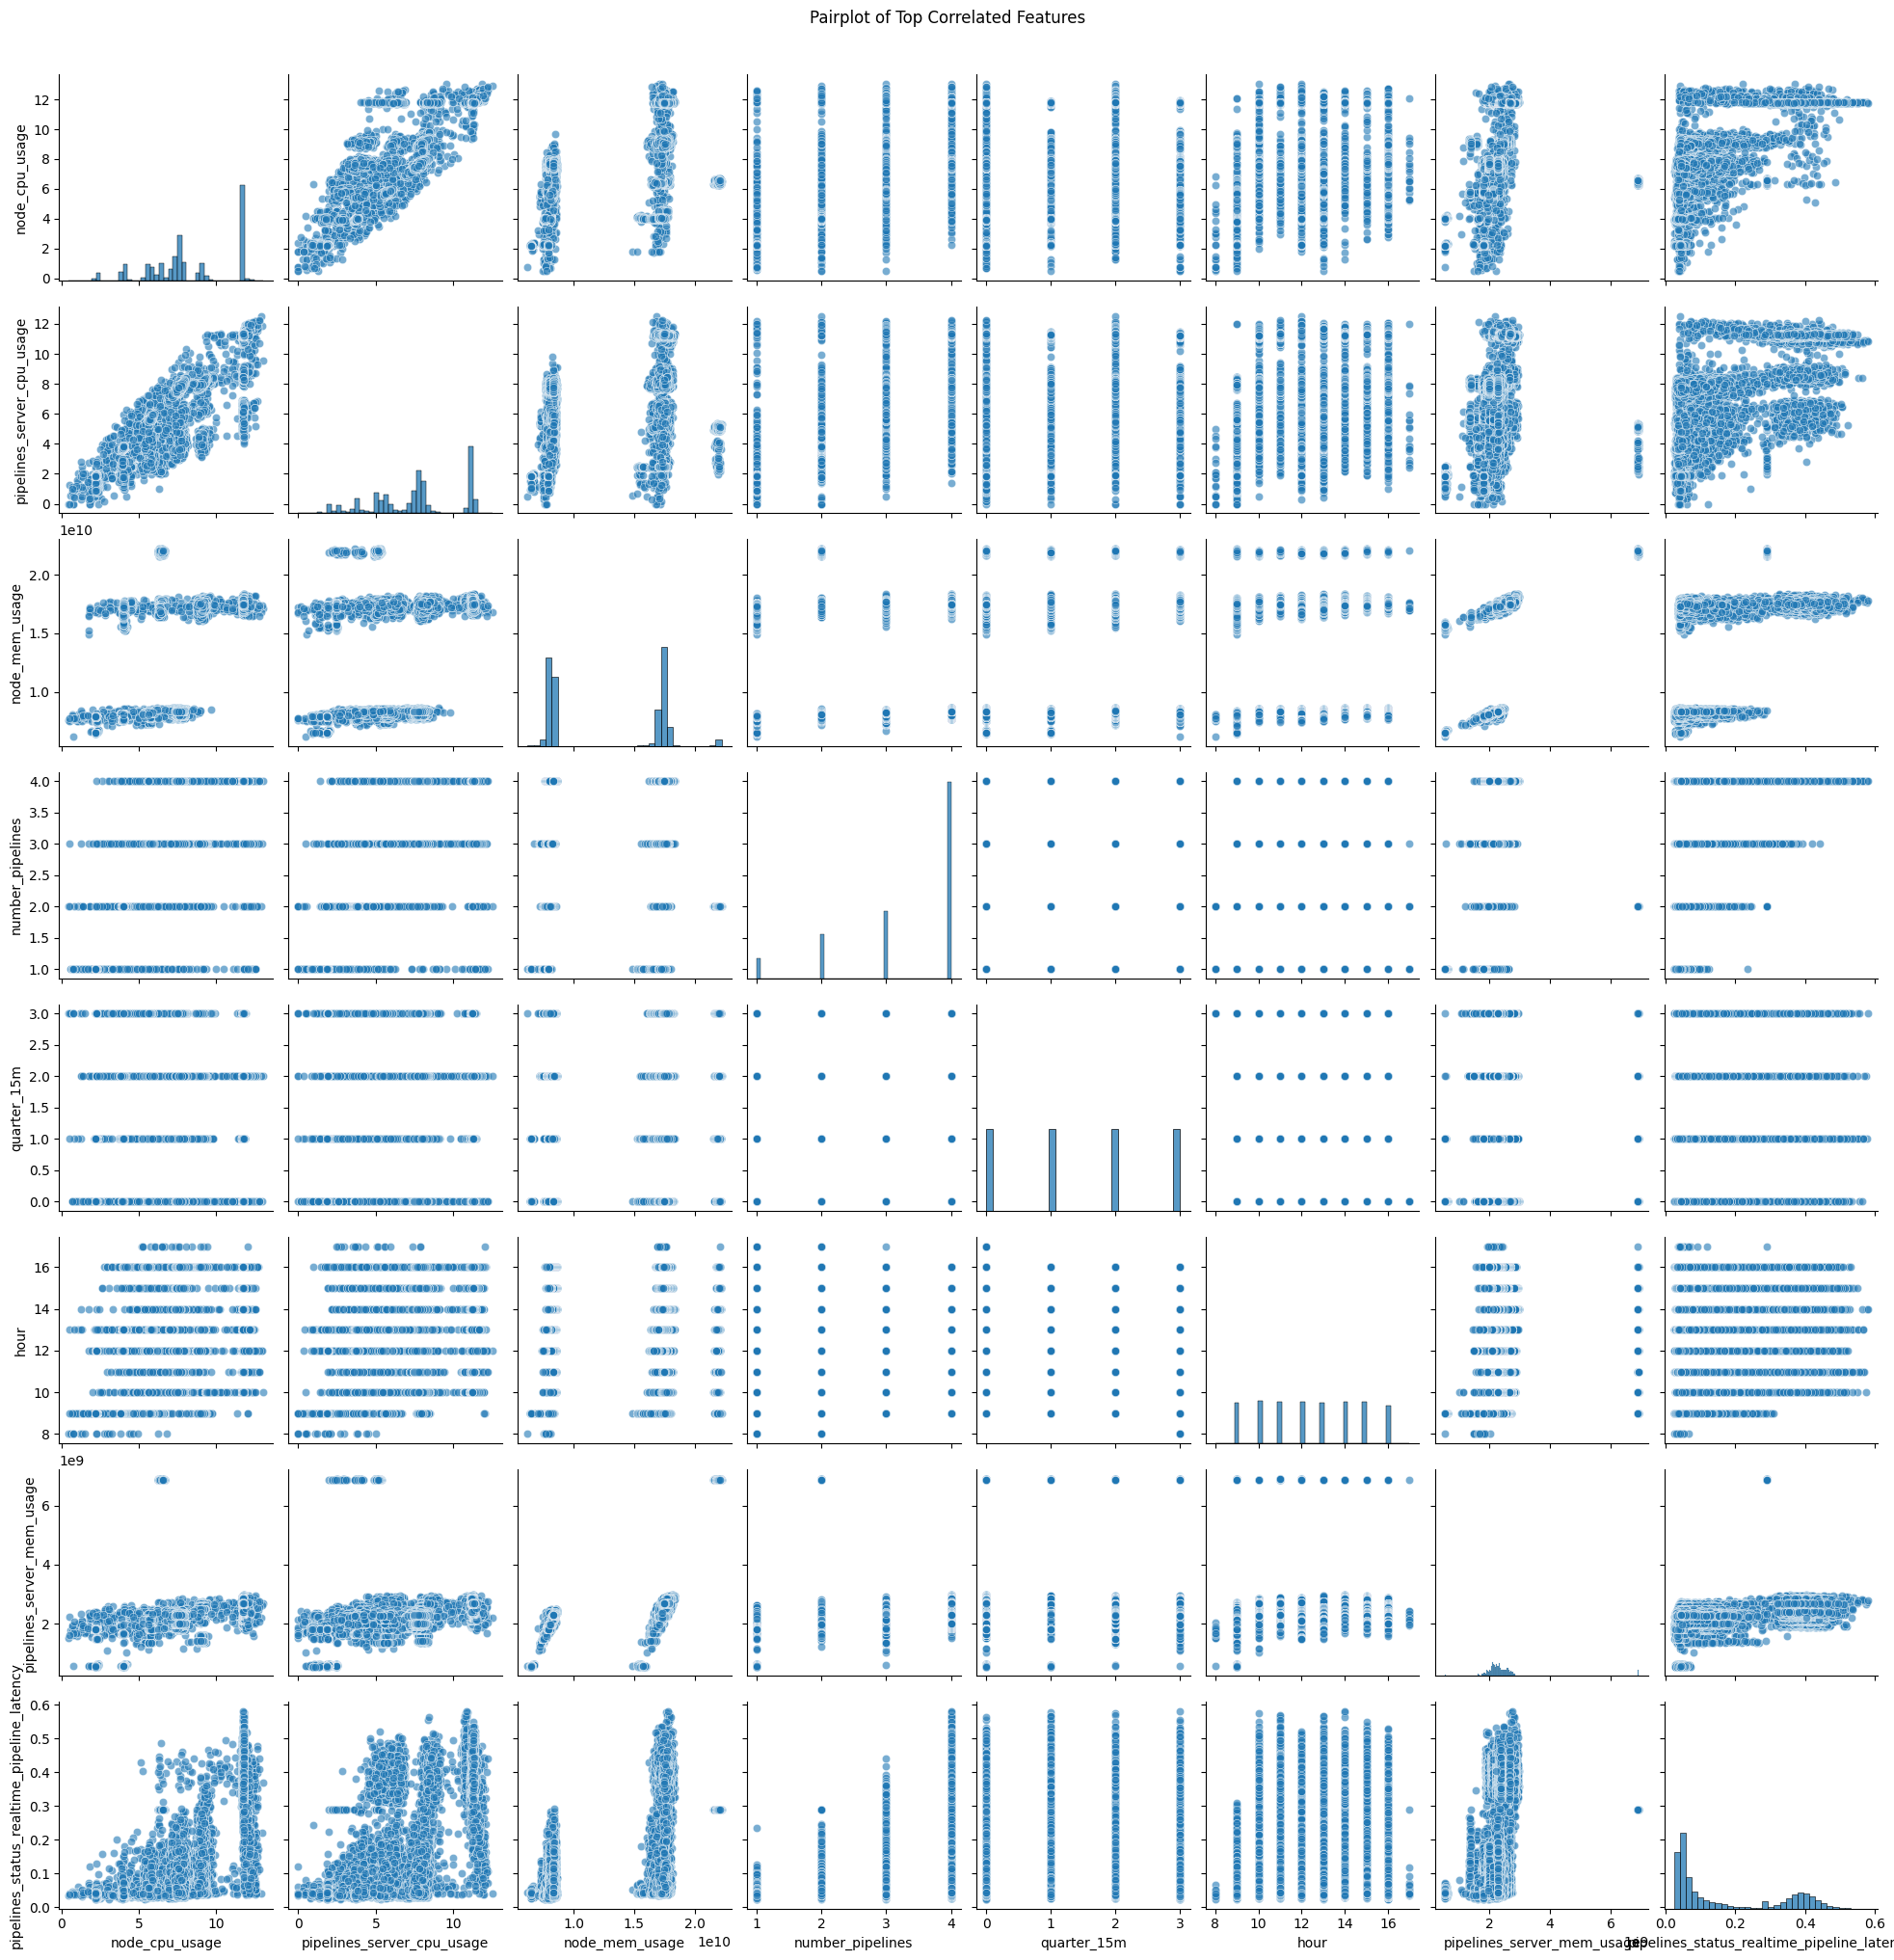

In [20]:
# Correlations with target variable only
target_correlations = correlation_data.corr()[TARGET].drop(TARGET).sort_values(key=abs, ascending=False)
# For a subset of most correlated features (to avoid overcrowding)
# top_features = target_correlations.head(6).index.tolist()  # Top 6 features
top_features=[
#  'pipelines_status_avg_pipeline_latency',
 'node_cpu_usage',
 'pipelines_server_cpu_usage',
 'node_mem_usage',
 'number_pipelines',
 'quarter_15m',
 'hour',
 'pipelines_server_mem_usage']
pairplot_data = train_data[top_features + [TARGET]]

sns.pairplot(pairplot_data, 
             diag_kind='hist',
             plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Top Correlated Features', y=1.02)
plt.show()

Notes for feature engineering:
- `node_cpu_usage` == `pipeline_server_cpu_usage`
- `node_mem_usage` == `pipeline_server_mem_usage`
- `hour` te la distribució que ens interessa, hauria d'interaccionar 
- `cluster` no apareix (cat) però és la que hauria de tenir més impacte i interaccions amb les principals.
- Amb `cluster`i `hour` i hauria d'haver màgia llavors amb les de cpu, mem etc.


Repetir l'analisis amb el dataset de means, potser està molt brut sinò.


- `pipelines_status_avg_pipeline_latency` to be excluded, multicollinearity.



# Linear Regression analysis

In [21]:
X_train_df
X_val_df
X_test_df

,num__pipelines_status_avg_fps,num__pipelines_status_avg_pipeline_latency,num__node_cpu_usage,num__node_mem_usage,num__pipelines_server_cpu_usage,num__pipelines_server_mem_usage,num__number_pipelines,num__minute,num__quarter_15m,num__hour,cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7
52944,0.209939,-1.010387,-1.501656,0.684086,-1.796029,-1.461901,-2.540223,-0.660292,-0.443483,-1.521520,0.0
52945,0.208820,-1.010156,-1.518217,0.703613,-1.824902,-1.465794,-2.540223,-0.660292,-0.443483,-1.521520,0.0
52946,0.211347,-1.009983,-1.518459,0.691224,-1.800288,-1.465296,-2.540223,-0.602575,-0.443483,-1.521520,0.0
52947,0.210257,-1.009963,-1.526800,0.676918,-1.802698,-1.461168,-2.540223,-0.602575,-0.443483,-1.521520,0.0
52948,0.210186,-1.010260,-1.508668,0.673450,-1.802942,-1.461586,-2.540223,-0.544859,-0.443483,-1.521520,0.0
...,...,...,...,...,...,...,...,...,...,...,...
66176,0.209449,-0.796351,-0.843449,-0.940831,-0.593971,-0.275371,-0.375770,1.590658,1.344482,1.557204,1.0
66177,0.209266,-0.795507,-0.835229,-0.985684,-0.569639,-0.270550,-0.375770,1.590658,1.344482,1.557204,1.0
66178,0.208886,-0.794577,-0.858197,-0.982840,-0.609821,-0.261126,-0.375770,1.648375,1.344482,1.557204,1.0
66179,0.208859,-0.795104,-0.875121,-0.977841,-0.678630,-0.264601,-0.375770,1.648375,1.344482,1.557204,1.0


In [22]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

X_train_with_const =  (X_train_df)
X_val_with_const =  (X_val_df)
X_test_with_const =  (X_test_df)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_with_const).fit()

# Print detailed results
print(ols_model.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.932
Model:                                                    OLS   Adj. R-squared (uncentered):              0.932
Method:                                         Least Squares   F-statistic:                          5.949e+04
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:56   Log-Likelihood:                          66783.
No. Observations:                                       47650   AIC:                                 -1.335e+05
Df Residuals:                                           47639   BIC:                                 -1.334e+05
Df Model:                                                  11                                           

# Simplified model

In [23]:
X_train_with_const =  (X_train_df.drop(columns=['num__pipelines_status_avg_pipeline_latency','num__pipelines_status_avg_fps','num__minute','num__quarter_15m']))
X_val_with_const =  (X_val_df)
X_test_with_const =  (X_test_df)



# Fit OLS model
ols_model = sm.OLS(y_train, X_train_with_const).fit()

# Print detailed results
print(ols_model.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.892
Model:                                                    OLS   Adj. R-squared (uncentered):              0.892
Method:                                         Least Squares   F-statistic:                          5.596e+04
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:56   Log-Likelihood:                          55615.
No. Observations:                                       47650   AIC:                                 -1.112e+05
Df Residuals:                                           47643   BIC:                                 -1.112e+05
Df Model:                                                   7                                           

# Interactions

In [24]:
# Create interaction terms
X_train_interact = X_train_df.drop(columns=['num__pipelines_status_avg_pipeline_latency','num__pipelines_status_avg_fps','num__minute','num__quarter_15m']).copy()

# 1. Node type (edge vs cloud) interactions
X_train_interact['cluster_x_pipelines'] = X_train_interact['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] * X_train_interact['num__number_pipelines']
X_train_interact['cluster_x_node_cpu'] = X_train_interact['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] * X_train_interact['num__node_cpu_usage']
X_train_interact['cluster_x_node_mem'] = X_train_interact['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] * X_train_interact['num__node_mem_usage']
X_train_interact['cluster_x_server_cpu'] = X_train_interact['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] * X_train_interact['num__pipelines_server_cpu_usage']
X_train_interact['cluster_x_server_mem'] = X_train_interact['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] * X_train_interact['num__pipelines_server_mem_usage']

# 2. Hour interactions (periodic patterns)
X_train_interact['hour_x_pipelines'] = X_train_interact['num__hour'] * X_train_interact['num__number_pipelines']
X_train_interact['hour_x_node_cpu'] = X_train_interact['num__hour'] * X_train_interact['num__node_cpu_usage']
X_train_interact['hour_x_server_cpu'] = X_train_interact['num__hour'] * X_train_interact['num__pipelines_server_cpu_usage']

# 3. Resource competition interactions (node vs app server)
X_train_interact['node_cpu_x_server_cpu'] = X_train_interact['num__node_cpu_usage'] * X_train_interact['num__pipelines_server_cpu_usage']
X_train_interact['node_mem_x_server_mem'] = X_train_interact['num__node_mem_usage'] * X_train_interact['num__pipelines_server_mem_usage']

# 4. Load-resource interactions
X_train_interact['pipelines_x_server_cpu'] = X_train_interact['num__number_pipelines'] * X_train_interact['num__pipelines_server_cpu_usage']
X_train_interact['pipelines_x_server_mem'] = X_train_interact['num__number_pipelines'] * X_train_interact['num__pipelines_server_mem_usage']

# 5. Quadratic non-linear behavior of num__number_pipelines:
X_train_interact['pipelines_squared'] = X_train_interact['num__number_pipelines'] ** 2


In [25]:
X_train_with_noconst = (X_train_interact)
base_ols_model_interact = sm.OLS(y_train, X_train_with_noconst).fit()
print(base_ols_model_interact.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.961
Model:                                                    OLS   Adj. R-squared (uncentered):              0.961
Method:                                         Least Squares   F-statistic:                          5.897e+04
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:57   Log-Likelihood:                          80093.
No. Observations:                                       47650   AIC:                                 -1.601e+05
Df Residuals:                                           47630   BIC:                                 -1.600e+05
Df Model:                                                  20                                           

# Final explanatory model, no future prediction 

1 increase standard deviation of each feature does the following:
- `node_mem_usage`adds 226ms - Memory Constrained.
- `number_pipelines` adds 127ms - Added workload effect.
- `cluster_x_number_pipelines` Cloud handles pipelines better. Reduction of 62ms per pipeline compared to Edge
- `cluster_x_node_mem` Cloud negates the memory impact. Everything works perfect there.
-  `node_cpu_x_server_cpu` interaction of the app usage and the cluster (server) usage.


In [26]:
X_train_with_const =  (X_train_interact.drop(columns=[

    'cluster_x_node_cpu','num__hour','hour_x_pipelines',
    'hour_x_server_cpu','hour_x_node_cpu','pipelines_x_server_mem',
    'pipelines_squared','pipelines_x_server_cpu','node_mem_x_server_mem',
    'cluster_x_server_mem','num__pipelines_server_mem_usage',
    'num__pipelines_server_cpu_usage',
    'num__node_cpu_usage',
    'cluster_x_server_cpu',
    'cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7',
    


    ]))
ols_model_interact = sm.OLS(y_train, X_train_with_const).fit()
print(ols_model_interact.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.953
Model:                                                    OLS   Adj. R-squared (uncentered):              0.953
Method:                                         Least Squares   F-statistic:                          1.929e+05
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:57   Log-Likelihood:                          75499.
No. Observations:                                       47650   AIC:                                 -1.510e+05
Df Residuals:                                           47645   BIC:                                 -1.509e+05
Df Model:                                                   5                                           

### OLS excluint Node-Server interactions. Teoricament l'aplicació està sola al node, no hi ha competició de recursos.

In [27]:
X_train_with_no_const = (X_train_interact.drop(columns=[

    'cluster_x_node_cpu','num__hour','hour_x_pipelines',
    'hour_x_server_cpu','hour_x_node_cpu','pipelines_x_server_mem',
    'pipelines_squared','pipelines_x_server_cpu','node_mem_x_server_mem',
    'cluster_x_server_mem','num__pipelines_server_mem_usage',
    'num__pipelines_server_cpu_usage',
    'num__node_cpu_usage',
    'cluster_x_server_cpu',
    'cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7',
    'node_cpu_x_server_cpu'


    ]))
ols_model_interact = sm.OLS(y_train, X_train_with_no_const).fit()
print(ols_model_interact.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.931
Model:                                                    OLS   Adj. R-squared (uncentered):              0.931
Method:                                         Least Squares   F-statistic:                          1.611e+05
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:57   Log-Likelihood:                          66432.
No. Observations:                                       47650   AIC:                                 -1.329e+05
Df Residuals:                                           47646   BIC:                                 -1.328e+05
Df Model:                                                   4                                           

# OLS adding lags of previous latency

Durbin-Watson shows autocorrelation of residuals over-time due to its time-series nature.
Linear Regression assumes independence of residuals, not correct. 

In [28]:
# Add temporal features
X_train_interact['latency_lag1'] = y_train.shift(1).fillna(y_train.mean())
X_train_interact['latency_lag2'] = y_train.shift(2).fillna(y_train.mean())
X_train_interact['latency_lag3'] = y_train.shift(3).fillna(y_train.mean())
X_train_interact['latency_lag4'] = y_train.shift(4).fillna(y_train.mean())
X_train_interact['latency_lag9'] = y_train.shift(9).fillna(y_train.mean())
X_train_interact['pipelines_lag1'] = X_train_interact['num__number_pipelines'].shift(1).fillna(0)


In [29]:
X_train_interact_no_const = X_train_interact.drop(columns=[
    'hour_x_pipelines','cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7',
    'cluster_x_node_mem','num__hour','hour_x_server_cpu','pipelines_x_server_mem',
    'pipelines_x_server_cpu','hour_x_node_cpu','cluster_x_node_cpu',
    'num__pipelines_server_mem_usage','pipelines_squared',
    'node_mem_x_server_mem','node_cpu_x_server_cpu',
    'num__node_cpu_usage',
    'latency_lag2',
    'latency_lag3',
    'latency_lag4',
    'latency_lag9',
    'num__pipelines_server_cpu_usage',
    'cluster_x_pipelines'
    ])
ols_model_interact = sm.OLS(y_train, X_train_interact_no_const).fit()
print(ols_model_interact.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.951
Model:                                                    OLS   Adj. R-squared (uncentered):              0.951
Method:                                         Least Squares   F-statistic:                          1.547e+05
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:57   Log-Likelihood:                          74624.
No. Observations:                                       47650   AIC:                                 -1.492e+05
Df Residuals:                                           47644   BIC:                                 -1.492e+05
Df Model:                                                   6                                           

In [30]:
X_train_interact_no_const = X_train_interact.drop(columns=[
    'hour_x_pipelines','cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7',
    'cluster_x_node_mem','num__hour','hour_x_server_cpu','pipelines_x_server_mem',
    'pipelines_x_server_cpu','hour_x_node_cpu','cluster_x_node_cpu',
    'num__pipelines_server_mem_usage','pipelines_squared',
    'node_mem_x_server_mem','node_cpu_x_server_cpu',
    'num__node_cpu_usage',
#
#
#
    'cluster_x_server_cpu','num__pipelines_server_cpu_usage','cluster_x_pipelines',
    'num__node_mem_usage','pipelines_lag1','num__number_pipelines','cluster_x_server_mem'
    
    ])
# Use HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors
ols_model = sm.OLS(y_train, X_train_interact_no_const).fit()
ols_robust = ols_model.get_robustcov_results(cov_type='HAC', maxlags=10)
print(ols_robust.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.961
Model:                                                    OLS   Adj. R-squared (uncentered):              0.961
Method:                                         Least Squares   F-statistic:                          2.136e+05
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:57   Log-Likelihood:                          79742.
No. Observations:                                       47650   AIC:                                 -1.595e+05
Df Residuals:                                           47645   BIC:                                 -1.594e+05
Df Model:                                                   5                                           

# Applying 1 difference. Removing the trend.

In [31]:
# Transform to changes rather than levels
y_diff = y_train.diff().dropna()
X_diff = X_train_interact.diff().dropna()

In [32]:
X_final=X_diff.drop(columns=[
    'node_mem_x_server_mem','hour_x_server_cpu','cluster_x_node_mem',
    'num__node_mem_usage','pipelines_x_server_mem','hour_x_pipelines',
    'hour_x_node_cpu','num__hour','pipelines_x_server_cpu',
    'num__pipelines_server_cpu_usage','node_cpu_x_server_cpu',
    'cluster_x_server_cpu','pipelines_squared','num__pipelines_server_mem_usage',
    'pipelines_lag1',
    ])
ols_diff = sm.OLS(y_diff, X_final).fit()
print(ols_diff.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.373
Model:                                                    OLS   Adj. R-squared (uncentered):              0.373
Method:                                         Least Squares   F-statistic:                              2578.
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:57   Log-Likelihood:                          82560.
No. Observations:                                       47649   AIC:                                 -1.651e+05
Df Residuals:                                           47638   BIC:                                 -1.650e+05
Df Model:                                                  11                                           

# Baseline Linear Regression future prediction

### Create windowed dataframe with mean values over 5 min and future latency values.

In [33]:
w = 10
n = (len(df) // w) * w
g = np.arange(n) // w

num_cols = df.select_dtypes(include=np.number).columns
non_num = df.columns.difference(num_cols)

agg = {**{c: 'mean' for c in num_cols}, **{c: 'last' for c in non_num}}
df_windows = df.iloc[:n].groupby(g).agg(agg)
df_windows.index = df.index[:n:w]

df_windows['target_next'] = df_windows['pipelines_status_realtime_pipeline_latency'].shift(-2)
# What is the point of predicting the next 5 min? By the time the pipeline finishes, we will be already 1min 30s into the next 5 min.
# Lets predict the mean of 5 minutes from the next 2 iterations. We predict from min +5 to +10.

# Remove the last 2 row (no future value available)
df_windows = df_windows[:-2]
df_windows.reset_index(drop=True, inplace=True)

In [34]:
df_windows

,pipelines_status_avg_fps,pipelines_status_avg_pipeline_latency,node_cpu_usage,node_mem_usage,pipelines_server_cpu_usage,pipelines_server_mem_usage,number_pipelines,minute,quarter_15m,hour,pipelines_status_realtime_pipeline_latency,cluster,date,target_next
0,15.090994,0.083243,6.036433,1.714037e+10,4.768147,2.288597e+09,2.0,3.0,0.0,9.0,0.057393,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:05:30,0.056161
1,15.019418,0.086806,6.488267,1.720025e+10,5.138889,2.289157e+09,2.0,8.0,0.0,9.0,0.064287,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:10:30,0.063861
2,15.011365,0.089988,6.411033,1.710693e+10,5.042925,2.288631e+09,2.0,13.0,0.2,9.0,0.056161,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:15:30,0.069371
3,15.008161,0.088683,6.465767,1.727254e+10,4.864561,2.288830e+09,2.0,18.0,1.0,9.0,0.063861,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:20:30,0.054544
4,15.006837,0.089954,6.437332,1.723279e+10,4.640629,2.290048e+09,2.0,23.0,1.0,9.0,0.069371,eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259,2025-07-29 09:25:30,0.132694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6611,15.004492,0.094750,5.632633,8.308484e+09,5.248380,2.172119e+09,3.0,26.0,1.0,16.0,0.038419,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:28:30,0.052384
6612,15.064652,0.087774,5.571567,8.391506e+09,5.266962,2.214846e+09,3.0,31.0,1.8,16.0,0.052180,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:33:30,0.058375
6613,15.006812,0.091142,5.864500,8.391442e+09,5.535275,2.194507e+09,3.0,36.0,2.0,16.0,0.052384,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:38:30,0.053662
6614,15.005032,0.092042,5.793733,8.344100e+09,5.713250,2.177150e+09,3.0,41.0,2.0,16.0,0.058375,fd7816db-7948-4602-af7a-1d51900792a7,2025-10-06 16:43:30,0.043525


### Train, val, test split

In [35]:
total_length = len(df_windows)
train_val_split = int(0.72 * total_length)  # End of training data
val_test_split = int(0.8 * total_length)    # Start of test data

# Create the splits
train_data = df_windows[:train_val_split]
validation_data = df_windows[train_val_split:val_test_split]
test_data = df_windows[val_test_split:]

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (4763, 14)
Validation data shape: (529, 14)
Test data shape: (1324, 14)


### Fit scaler and onehotencoder.

In [36]:
print(df_windows.dtypes)
df_windows.cluster=df_windows.cluster.astype("category")

pipelines_status_avg_fps                             float64
pipelines_status_avg_pipeline_latency                float64
node_cpu_usage                                       float64
node_mem_usage                                       float64
pipelines_server_cpu_usage                           float64
pipelines_server_mem_usage                           float64
number_pipelines                                     float64
minute                                               float64
quarter_15m                                          float64
hour                                                 float64
pipelines_status_realtime_pipeline_latency           float64
cluster                                             category
date                                          datetime64[ns]
target_next                                          float64
dtype: object


In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Dynamically identify features
all_features = train_data.columns.tolist()
exclude_columns = ['cluster', 'date', TARGET]  # TARGET is your target variable
numerical_features = [col for col in all_features if col not in exclude_columns]
categorical_features = ['cluster']

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
    ]
)

# Separate features and target (excluding date column)
features_to_keep = numerical_features + categorical_features
X_train = train_data[features_to_keep]
X_val = validation_data[features_to_keep]
X_test = test_data[features_to_keep]

y_train = train_data[TARGET]
y_val = validation_data[TARGET]
y_test = test_data[TARGET]

# Fit on training data and transform all splits
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"Original training shape: {X_train.shape}")
print(f"Processed training shape: {X_train_processed.shape}")
print(f"Processed validation shape: {X_val_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")

Numerical features: ['pipelines_status_avg_fps', 'pipelines_status_avg_pipeline_latency', 'node_cpu_usage', 'node_mem_usage', 'pipelines_server_cpu_usage', 'pipelines_server_mem_usage', 'number_pipelines', 'minute', 'quarter_15m', 'hour', 'target_next']
Categorical features: ['cluster']
Original training shape: (4763, 12)
Processed training shape: (4763, 12)
Processed validation shape: (529, 12)
Processed test shape: (1324, 12)


### Keep feature names

In [38]:
# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Convert back to DataFrame if needed
X_train_df_windows = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_val_df_windows = pd.DataFrame(X_val_processed, columns=feature_names, index=X_val.index)
X_test_df_windows = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

In [39]:
X_train_df_windows

,num__pipelines_status_avg_fps,num__pipelines_status_avg_pipeline_latency,num__node_cpu_usage,num__node_mem_usage,num__pipelines_server_cpu_usage,num__pipelines_server_mem_usage,num__number_pipelines,num__minute,num__quarter_15m,num__hour,num__target_next,cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7
0,0.276937,-0.849140,-0.805785,0.899035,-1.060866,-0.117166,-1.501480,-1.667448,-1.438778,-1.536250,-0.751784,0.0
1,0.233982,-0.823281,-0.640054,0.911588,-0.918649,-0.116382,-1.501480,-1.352238,-1.438778,-1.536250,-0.700237,0.0
2,0.229149,-0.800190,-0.668383,0.892025,-0.955460,-0.117118,-1.501480,-1.037028,-1.246519,-1.536250,-0.663357,0.0
3,0.227227,-0.809659,-0.648306,0.926743,-1.023881,-0.116840,-1.501480,-0.721818,-0.477480,-1.536250,-0.762607,0.0
4,0.226432,-0.800440,-0.658736,0.918410,-1.109782,-0.115132,-1.501480,-0.406608,-0.477480,-1.536250,-0.239470,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4758,0.226388,-0.609192,-0.326062,-0.939405,-0.159446,-0.134582,0.727980,0.602064,0.483818,-1.092253,-0.364930,1.0
4759,0.225496,-0.613886,-0.215093,-0.934795,0.000479,-0.132063,0.727980,0.917274,0.868337,-1.092253,-0.610282,1.0
4760,0.224719,-0.604744,-0.183853,-0.939128,-0.336844,-0.132280,0.727980,1.232484,1.445116,-1.092253,-0.758696,1.0
4761,0.224446,-0.589901,-0.217942,-0.941136,0.102224,-0.132667,0.727980,1.547694,1.445116,-1.092253,-0.607577,1.0


In [40]:
# Add your best interactions
X_train_df_windows['cluster_x_pipelines'] = (X_train_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] * 
                                    X_train_df_windows['num__number_pipelines'])
X_train_df_windows['cluster_x_node_mem'] = (X_train_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] * 
                                   X_train_df_windows['num__node_mem_usage'])
X_train_df_windows['node_cpu_x_server_cpu'] = (X_train_df_windows['num__node_cpu_usage'] * 
                                      X_train_df_windows['num__pipelines_server_cpu_usage'])

In [41]:
# Fit OLS for forecasting
X_train_noconst = (X_train_df_windows.drop(columns=[
    'num__quarter_15m','num__minute','num__pipelines_status_avg_fps','num__pipelines_status_avg_pipeline_latency',
    'num__hour','num__pipelines_server_mem_usage','num__pipelines_server_cpu_usage',
    'num__node_cpu_usage','cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7',
    'num__target_next'
    


    ]))
forecast_model = sm.OLS(y_train, X_train_noconst).fit()
print(forecast_model.summary())


                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.986
Model:                                                    OLS   Adj. R-squared (uncentered):              0.986
Method:                                         Least Squares   F-statistic:                          6.491e+04
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:33:57   Log-Likelihood:                          10434.
No. Observations:                                        4763   AIC:                                 -2.086e+04
Df Residuals:                                            4758   BIC:                                 -2.083e+04
Df Model:                                                   5                                           

# Error analysis forecasting in the next 5-10 min range

### Create interactions

In [42]:
# Add interactions to TRAINING set
X_train_df_windows['cluster_x_pipelines'] = (
    X_train_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_train_df_windows['num__number_pipelines']
)
X_train_df_windows['cluster_x_node_mem'] = (
    X_train_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_train_df_windows['num__node_mem_usage']
)
X_train_df_windows['node_cpu_x_server_cpu'] = (
    X_train_df_windows['num__node_cpu_usage'] *
    X_train_df_windows['num__pipelines_server_cpu_usage']
)

# Add interactions to VALIDATION set
X_val_df_windows['cluster_x_pipelines'] = (
    X_val_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_val_df_windows['num__number_pipelines']
)
X_val_df_windows['cluster_x_node_mem'] = (
    X_val_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_val_df_windows['num__node_mem_usage']
)
X_val_df_windows['node_cpu_x_server_cpu'] = (
    X_val_df_windows['num__node_cpu_usage'] *
    X_val_df_windows['num__pipelines_server_cpu_usage']
)

# Add interactions to TEST set
X_test_df_windows['cluster_x_pipelines'] = (
    X_test_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_test_df_windows['num__number_pipelines']
)
X_test_df_windows['cluster_x_node_mem'] = (
    X_test_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_test_df_windows['num__node_mem_usage']
)
X_test_df_windows['node_cpu_x_server_cpu'] = (
    X_test_df_windows['num__node_cpu_usage'] *
    X_test_df_windows['num__pipelines_server_cpu_usage']
)

### Generate predictions

In [43]:
feature_cols=['num__node_mem_usage', 'num__number_pipelines',
                'cluster_x_pipelines', 'cluster_x_node_mem',
                'node_cpu_x_server_cpu']

# Use same feature columns for validation and test
X_train_final = X_train_df_windows[feature_cols]
X_val_final = X_val_df_windows[feature_cols]
X_test_final = X_test_df_windows[feature_cols]

# Generate predictions
y_pred_train = forecast_model.predict(X_train_final)
y_pred_val = forecast_model.predict(X_val_final)
y_pred_test = forecast_model.predict(X_test_final)

### Evaluate


Training Set - Forecasting 5 to 10 min ahead
MAE:  0.0211
RMSE: 0.0271
R²:   0.9672
MAPE: 23.76%

Error Percentiles:
50th: 0.0174 (median error)
90th: 0.0437
95th: 0.0541

Validation Set - Forecasting 5 to 10 min ahead
MAE:  0.0332
RMSE: 0.0655
R²:   0.7929
MAPE: 28.03%

Error Percentiles:
50th: 0.0174 (median error)
90th: 0.0540
95th: 0.1558

Test Set - Forecasting 5 to 10 min ahead
MAE:  0.0209
RMSE: 0.0275
R²:   0.9645
MAPE: 25.48%

Error Percentiles:
50th: 0.0167 (median error)
90th: 0.0454
95th: 0.0596


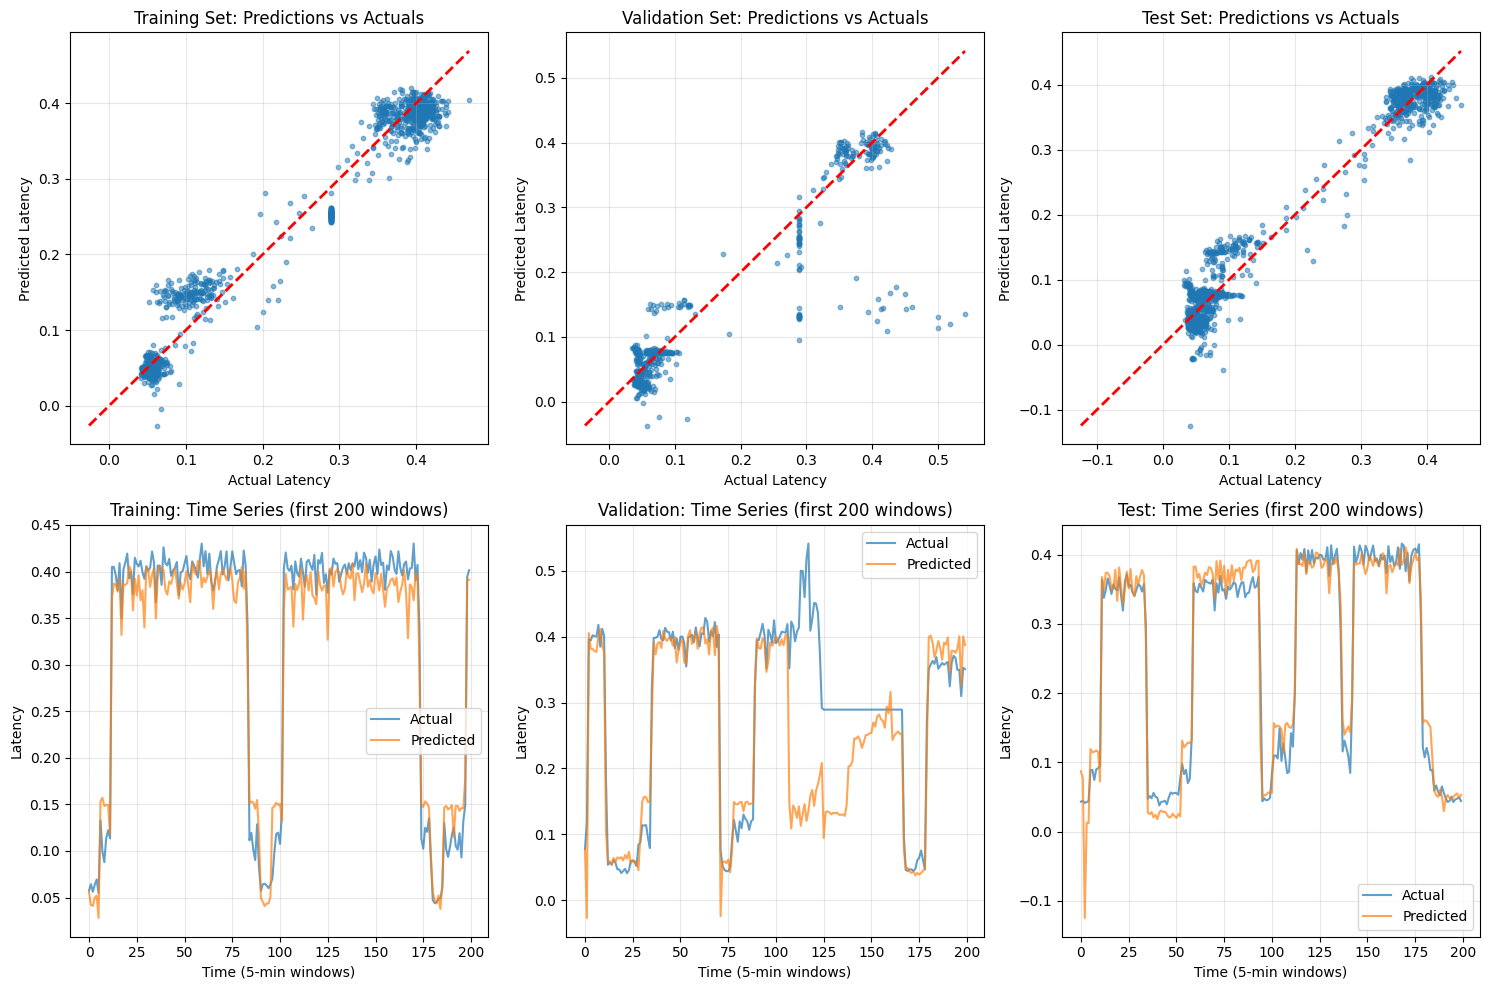

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

def evaluate_predictions(y_true, y_pred, set_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Handle MAPE carefully (avoid division by zero)
    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # Percentile errors
    errors = np.abs(y_true - y_pred)
    p50 = np.percentile(errors, 50)
    p90 = np.percentile(errors, 90)
    p95 = np.percentile(errors, 95)
    
    print(f"\n{'='*50}")
    print(f"{set_name} Set - Forecasting 5 to 10 min ahead")
    print(f"{'='*50}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"\nError Percentiles:")
    print(f"50th: {p50:.4f} (median error)")
    print(f"90th: {p90:.4f}")
    print(f"95th: {p95:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'errors': errors}

# Evaluate all sets
train_metrics = evaluate_predictions(y_train, y_pred_train, "Training")
val_metrics = evaluate_predictions(y_val, y_pred_val, "Validation")
test_metrics = evaluate_predictions(y_test, y_pred_test, "Test")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Scatter plots
for idx, (y_true, y_pred, title) in enumerate([
    (y_train[:1000], y_pred_train[:1000], 'Training'),
    (y_val, y_pred_val, 'Validation'),
    (y_test, y_pred_test, 'Test')
]):
    ax = axes[0, idx]
    ax.scatter(y_true, y_pred, alpha=0.5, s=10)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax.set_xlabel('Actual Latency')
    ax.set_ylabel('Predicted Latency')
    ax.set_title(f'{title} Set: Predictions vs Actuals')
    ax.grid(True, alpha=0.3)

# Time series plots
for idx, (y_true, y_pred, title) in enumerate([
    (y_train[:200], y_pred_train[:200], 'Training'),
    (y_val[:200], y_pred_val[:200], 'Validation'),
    (y_test[:200], y_pred_test[:200], 'Test')
]):
    ax = axes[1, idx]
    ax.plot(range(len(y_true)), y_true.values, label='Actual', alpha=0.7)
    ax.plot(range(len(y_pred)), y_pred, label='Predicted', alpha=0.7)
    ax.set_xlabel('Time (5-min windows)')
    ax.set_ylabel('Latency')
    ax.set_title(f'{title}: Time Series (first 200 windows)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Error analysis

In [45]:
# Residual analysis for test set
residuals_test = y_test - y_pred_test

print("\n" + "="*50)
print("Residual Statistics")
print("="*50)
print(f"Mean residual: {residuals_test.mean():.4f}")
print(f"Std residual:  {residuals_test.std():.4f}")
print(f"Min residual:  {residuals_test.min():.4f}")
print(f"Max residual:  {residuals_test.max():.4f}")

# Error by cluster type
cluster_col = 'cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'
edge_mask = X_test_df_windows[cluster_col] == 0
cloud_mask = X_test_df_windows[cluster_col] == 1

print("\n" + "="*50)
print("Performance by Node Type")
print("="*50)

if edge_mask.any():
    edge_r2 = r2_score(y_test[edge_mask], y_pred_test[edge_mask])
    edge_mae = mean_absolute_error(y_test[edge_mask], y_pred_test[edge_mask])
    print(f"Edge Nodes  - R²: {edge_r2:.4f}, MAE: {edge_mae:.4f}")

if cloud_mask.any():
    cloud_r2 = r2_score(y_test[cloud_mask], y_pred_test[cloud_mask])
    cloud_mae = mean_absolute_error(y_test[cloud_mask], y_pred_test[cloud_mask])
    print(f"Cloud Nodes - R²: {cloud_r2:.4f}, MAE: {cloud_mae:.4f}")


Residual Statistics
Mean residual: -0.0015
Std residual:  0.0275
Min residual:  -0.0810
Max residual:  0.1662

Performance by Node Type
Edge Nodes  - R²: 0.9492, MAE: 0.0257
Cloud Nodes - R²: -0.6691, MAE: 0.0161


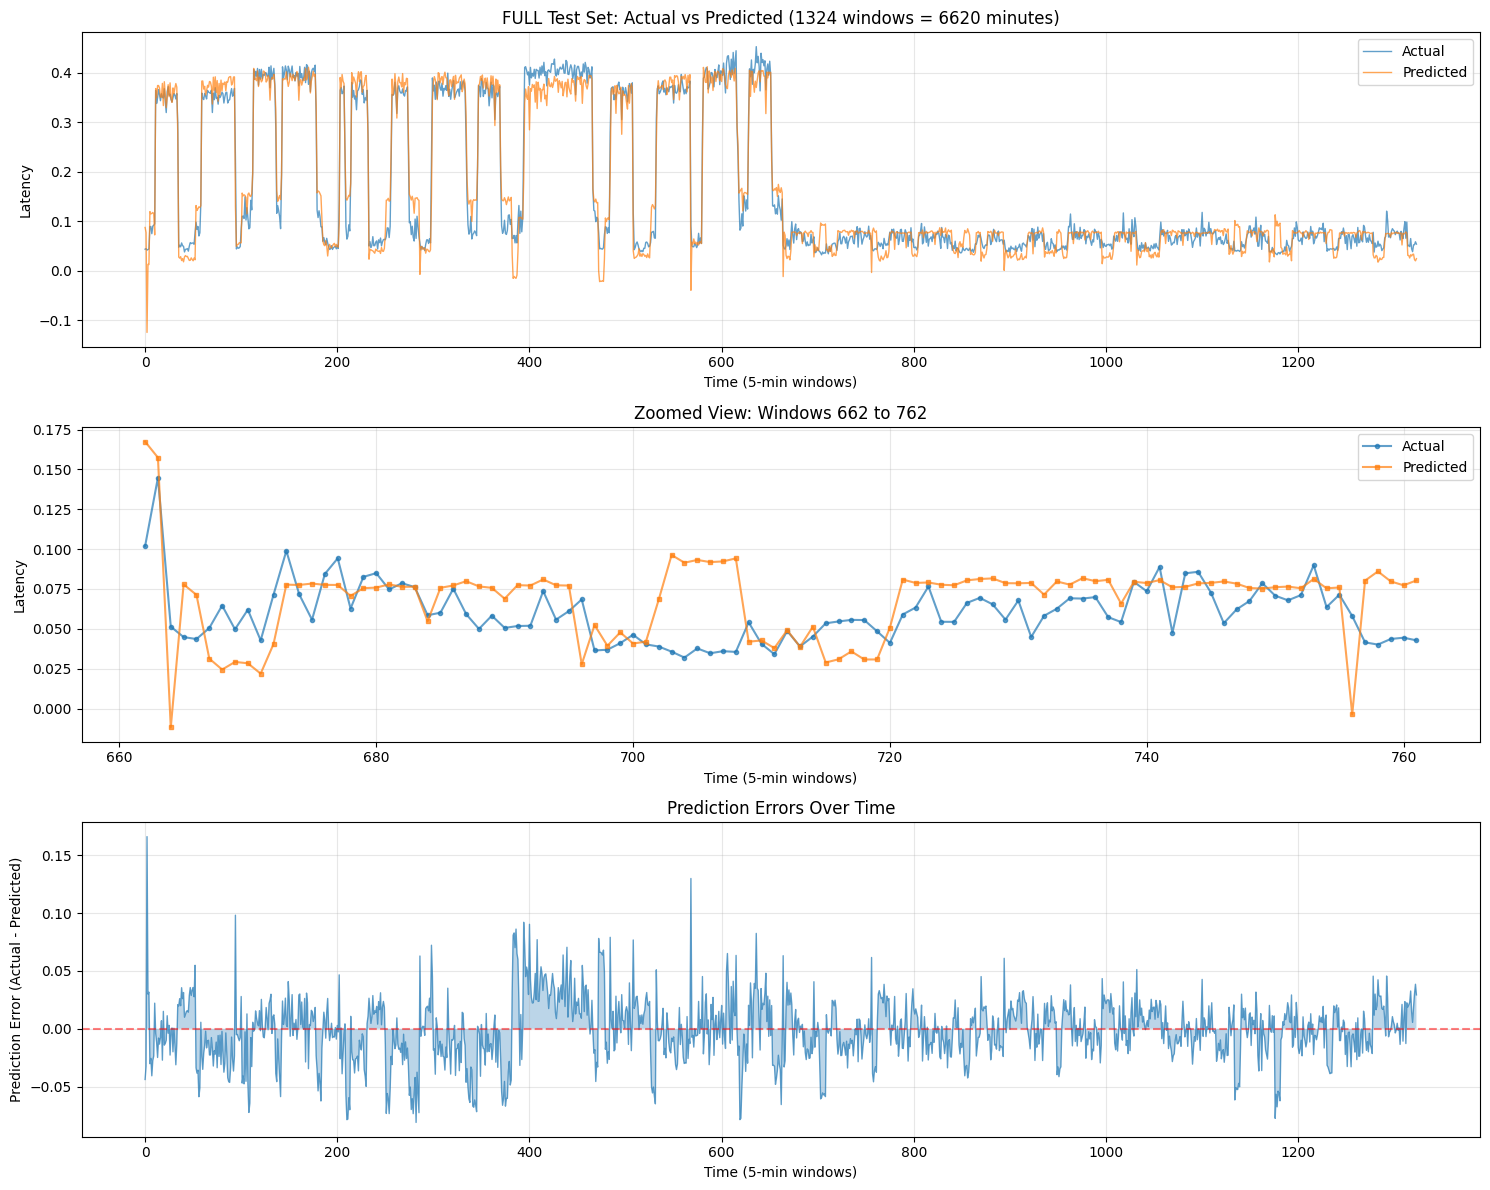


Test Set Size: 1324 windows (6620 minutes)
Time span: 110.3 hours


In [46]:
# Create a dedicated figure for full test set
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Full test set time series
ax1 = axes[0]
ax1.plot(range(len(y_test)), y_test.values, label='Actual', alpha=0.7, linewidth=1)
ax1.plot(range(len(y_pred_test)), y_pred_test, label='Predicted', alpha=0.7, linewidth=1)
ax1.set_xlabel('Time (5-min windows)')
ax1.set_ylabel('Latency')
ax1.set_title(f'FULL Test Set: Actual vs Predicted ({len(y_test)} windows = {len(y_test)*5} minutes)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Zoomed view (middle section)
start_idx = len(y_test) // 2
end_idx = start_idx + 100
ax2 = axes[1]
ax2.plot(range(start_idx, end_idx), y_test.iloc[start_idx:end_idx].values, 
         label='Actual', marker='o', markersize=3, alpha=0.7)
ax2.plot(range(start_idx, end_idx), y_pred_test[start_idx:end_idx], 
         label='Predicted', marker='s', markersize=3, alpha=0.7)
ax2.set_xlabel('Time (5-min windows)')
ax2.set_ylabel('Latency')
ax2.set_title(f'Zoomed View: Windows {start_idx} to {end_idx}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Prediction Error over time
ax3 = axes[2]
errors = y_test.values - y_pred_test
ax3.plot(range(len(errors)), errors, alpha=0.7, linewidth=1)
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax3.fill_between(range(len(errors)), errors, 0, alpha=0.3)
ax3.set_xlabel('Time (5-min windows)')
ax3.set_ylabel('Prediction Error (Actual - Predicted)')
ax3.set_title('Prediction Errors Over Time')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary stats
print(f"\nTest Set Size: {len(y_test)} windows ({len(y_test)*5} minutes)")
print(f"Time span: {len(y_test)*5/60:.1f} hours")

### Separate plots Edge - Cloud

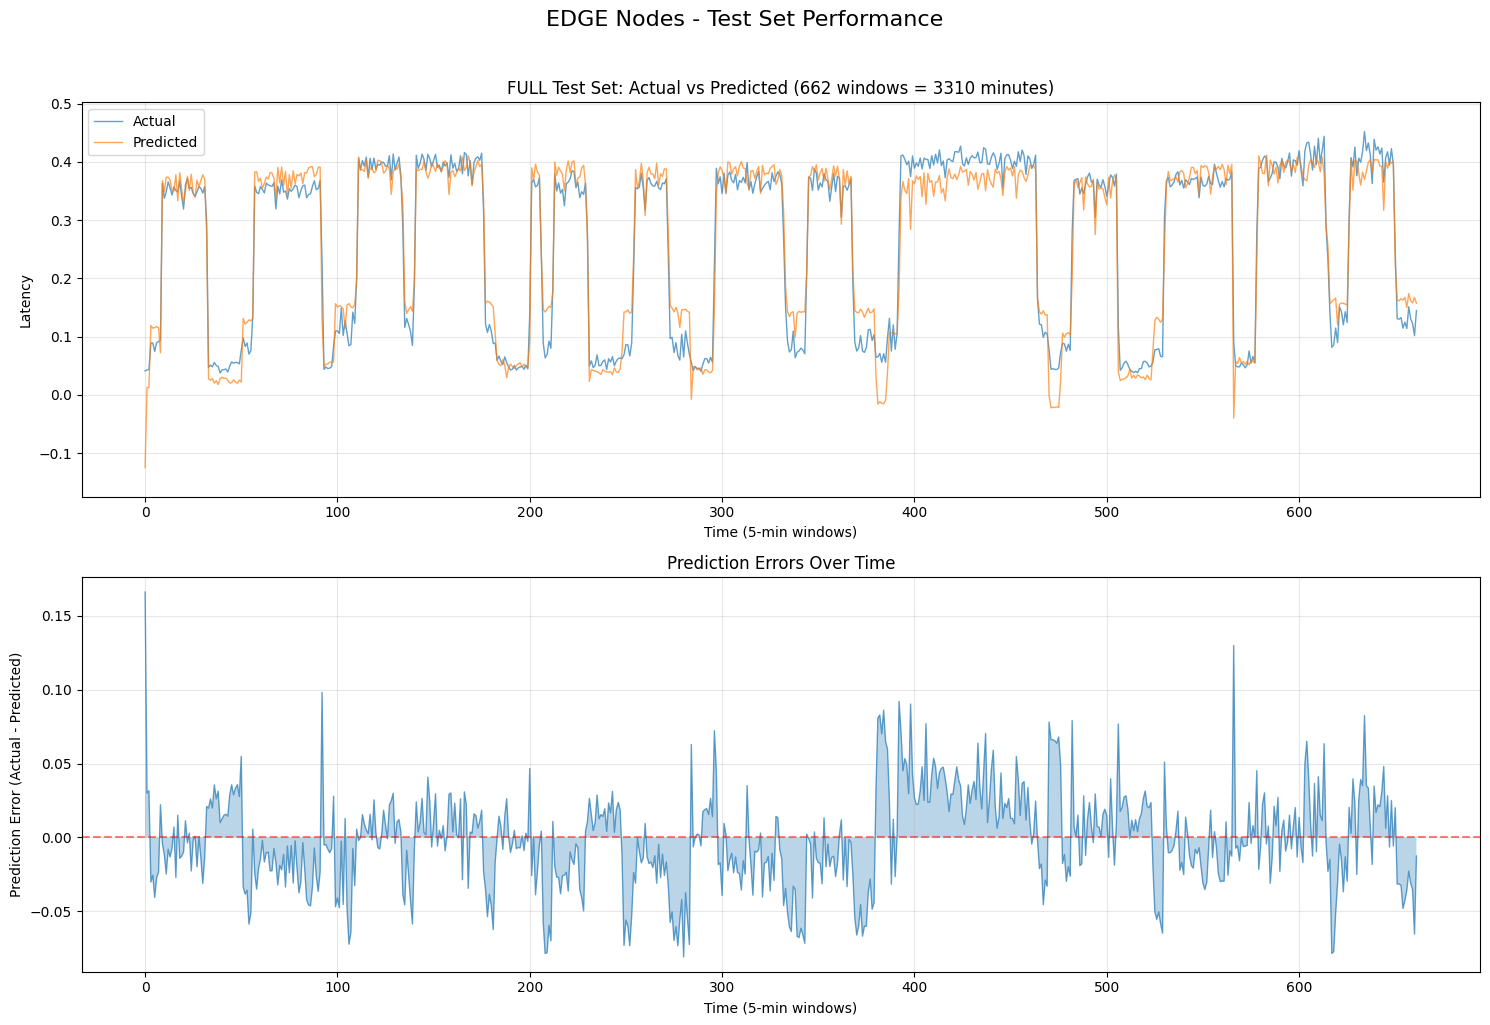


EDGE Nodes Summary:
  Test Set Size: 662 windows (3310 minutes)
  Time span: 55.2 hours
  MAE: 0.0257
  RMSE: 0.0331
  R²: 0.9492


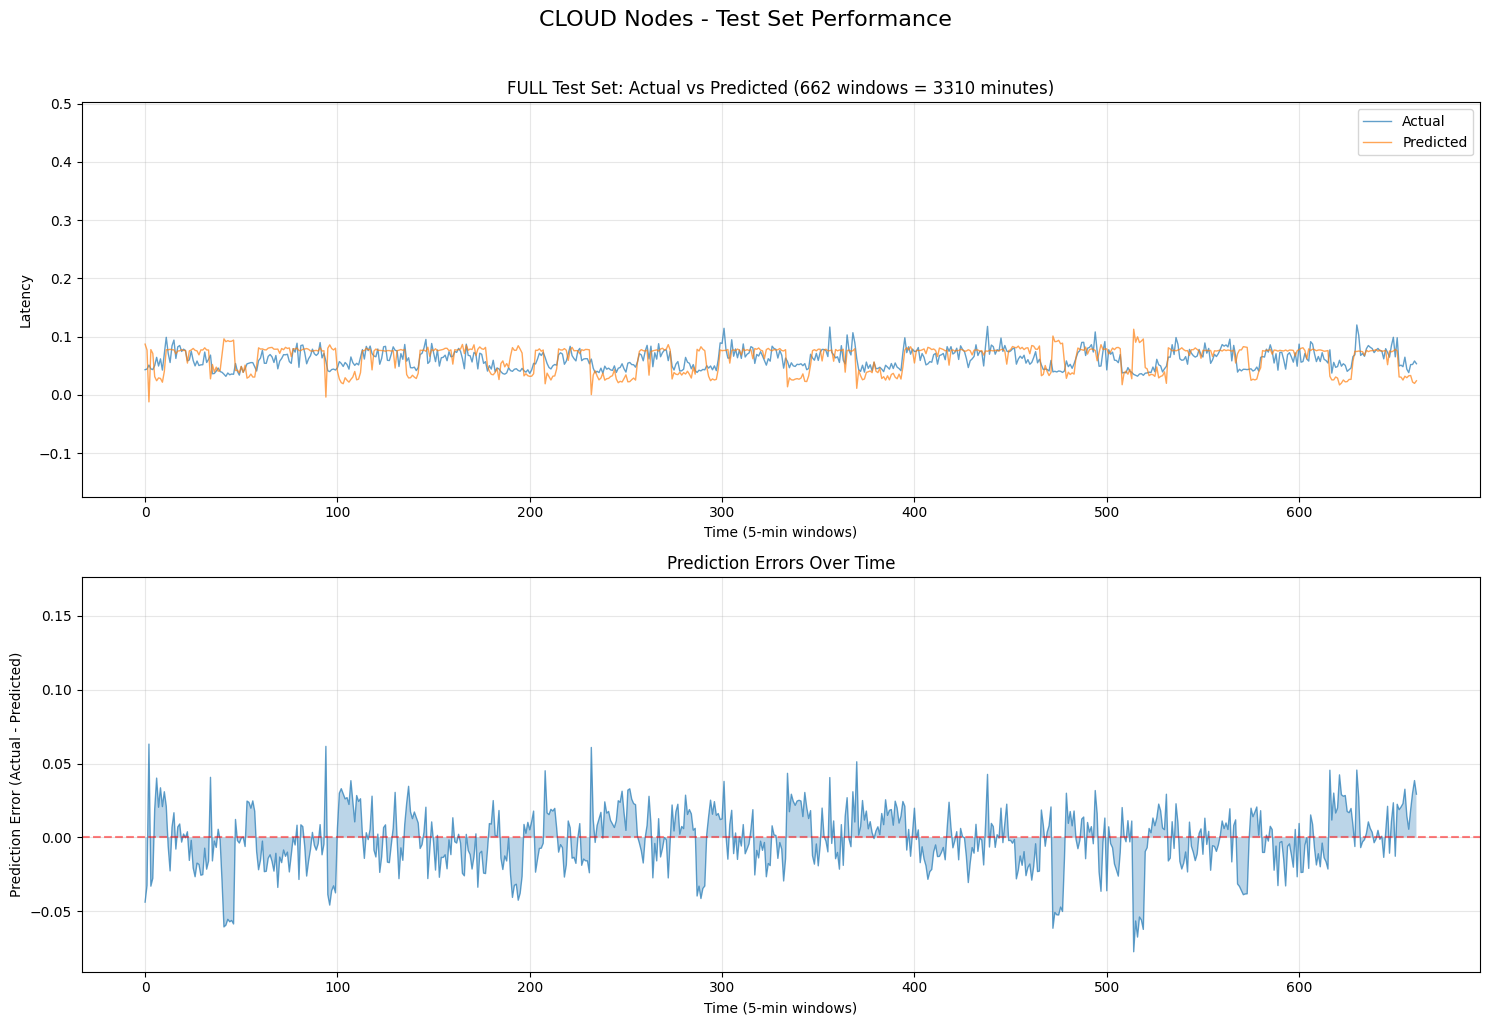


CLOUD Nodes Summary:
  Test Set Size: 662 windows (3310 minutes)
  Time span: 55.2 hours
  MAE: 0.0161
  RMSE: 0.0206
  R²: -0.6691

PERFORMANCE COMPARISON
Edge  - MAE: 0.0257, R²: 0.9492
Cloud - MAE: 0.0161, R²: -0.6691


In [47]:
# Get cluster column
cluster_col = 'cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'

# Create masks for each cluster type
edge_mask = X_test_df_windows[cluster_col] == 0
cloud_mask = X_test_df_windows[cluster_col] == 1

# Get global min/max for consistent scaling
y_min = min(y_test.min(), y_pred_test.min())
y_max = max(y_test.max(), y_pred_test.max())

# Get error range for consistent scaling
all_errors = y_test.values - y_pred_test
error_min = all_errors.min()
error_max = all_errors.max()

# Function to create plots for each cluster
def plot_cluster_predictions(mask, cluster_name, y_true, y_pred):
    if not mask.any():
        print(f"No {cluster_name} nodes in test set")
        return
    
    # Filter data for this cluster
    y_cluster = y_true[mask]
    y_pred_cluster = y_pred[mask]
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(f'{cluster_name} Nodes - Test Set Performance', fontsize=16, y=1.02)
    
    # Plot 1: Full test set time series
    ax1 = axes[0]
    ax1.plot(range(len(y_cluster)), y_cluster.values, label='Actual', 
             alpha=0.7, linewidth=1)  # Default blue
    ax1.plot(range(len(y_pred_cluster)), y_pred_cluster, label='Predicted', 
             alpha=0.7, linewidth=1)  # Default orange
    ax1.set_xlabel('Time (5-min windows)')
    ax1.set_ylabel('Latency')
    ax1.set_title(f'FULL Test Set: Actual vs Predicted ({len(y_cluster)} windows = {len(y_cluster)*5} minutes)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(y_min - 0.05, y_max + 0.05)  # Set consistent y-axis limits
    
    # Plot 2: Prediction Error over time
    ax2 = axes[1]
    errors = y_cluster.values - y_pred_cluster
    ax2.plot(range(len(errors)), errors, alpha=0.7, linewidth=1)  # Default color
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax2.fill_between(range(len(errors)), errors, 0, alpha=0.3)
    ax2.set_xlabel('Time (5-min windows)')
    ax2.set_ylabel('Prediction Error (Actual - Predicted)')
    ax2.set_title('Prediction Errors Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(error_min - 0.01, error_max + 0.01)  # Set consistent error scale
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    r2 = r2_score(y_cluster, y_pred_cluster)
    
    print(f"\n{cluster_name} Nodes Summary:")
    print(f"  Test Set Size: {len(y_cluster)} windows ({len(y_cluster)*5} minutes)")
    print(f"  Time span: {len(y_cluster)*5/60:.1f} hours")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")

# Create plots for Edge nodes
plot_cluster_predictions(edge_mask, "EDGE", y_test, y_pred_test)

# Create plots for Cloud nodes  
plot_cluster_predictions(cloud_mask, "CLOUD", y_test, y_pred_test)

# Print comparison
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

for mask, cluster_name in [(edge_mask, 'Edge'), (cloud_mask, 'Cloud')]:
    if mask.any():
        y_cluster = y_test[mask]
        y_pred_cluster = y_pred_test[mask]
        mae = mean_absolute_error(y_cluster, y_pred_cluster)
        r2 = r2_score(y_cluster, y_pred_cluster)
        print(f"{cluster_name:5} - MAE: {mae:.4f}, R²: {r2:.4f}")

# Fitting the OLS on unscaled features for production:
We will only need to onehotencode and create the interactions in our dataset. 

In [54]:
total_length = len(df_windows)
train_val_split = int(0.72 * total_length)  # End of training data
val_test_split = int(0.8 * total_length)    # Start of test data

# Create the splits
train_data = df_windows[:train_val_split]
validation_data = df_windows[train_val_split:val_test_split]
test_data = df_windows[val_test_split:]

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (4763, 14)
Validation data shape: (529, 14)
Test data shape: (1324, 14)


In [55]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Dynamically identify features
all_features = train_data.columns.tolist()
exclude_columns = ['cluster', 'date', TARGET]  # TARGET is your target variable
numerical_features = ['node_cpu_usage', 'node_mem_usage', 'number_pipelines', 'pipelines_server_cpu_usage']
categorical_features = ['cluster']

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', "passthrough", numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
    ]
)

# Separate features and target (excluding date column)
features_to_keep = numerical_features + categorical_features
X_train = train_data[features_to_keep]
X_val = validation_data[features_to_keep]
X_test = test_data[features_to_keep]

y_train = train_data[TARGET]
y_val = validation_data[TARGET]
y_test = test_data[TARGET]

# Fit on training data and transform all splits
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)

print(f"Original training shape: {X_train.shape}")
print(f"Processed training shape: {X_train_encoded.shape}")
print(f"Processed validation shape: {X_val_encoded.shape}")
print(f"Processed test shape: {X_test_encoded.shape}")

# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Convert back to DataFrame if needed
X_train_df_windows = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_val_df_windows = pd.DataFrame(X_val_encoded, columns=feature_names, index=X_val.index)
X_test_df_windows = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)


# Add interactions to TRAINING set
X_train_df_windows['cluster_x_pipelines'] = (
    X_train_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_train_df_windows['num__number_pipelines']
)
X_train_df_windows['cluster_x_node_mem'] = (
    X_train_df_windows['cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'] *
    X_train_df_windows['num__node_mem_usage']
)
X_train_df_windows['node_cpu_x_server_cpu'] = (
    X_train_df_windows['num__node_cpu_usage'] *
    X_train_df_windows['num__pipelines_server_cpu_usage']
)

X_train_df_windows.drop(columns=['num__node_cpu_usage','num__pipelines_server_cpu_usage','cat__cluster_fd7816db-7948-4602-af7a-1d51900792a7'], inplace=True)


Numerical features: ['node_cpu_usage', 'node_mem_usage', 'number_pipelines', 'pipelines_server_cpu_usage']
Categorical features: ['cluster']
Original training shape: (4763, 5)
Processed training shape: (4763, 5)
Processed validation shape: (529, 5)
Processed test shape: (1324, 5)


In [56]:
X_train_df_windows

,num__node_mem_usage,num__number_pipelines,cluster_x_pipelines,cluster_x_node_mem,node_cpu_x_server_cpu
0,1.714037e+10,2.0,0.0,0.000000e+00,28.782599
1,1.720025e+10,2.0,0.0,0.000000e+00,33.342480
2,1.710693e+10,2.0,0.0,0.000000e+00,32.330363
3,1.727254e+10,2.0,0.0,0.000000e+00,31.453116
4,1.723279e+10,2.0,0.0,0.000000e+00,29.873269
...,...,...,...,...,...
4758,8.370619e+09,4.0,4.0,8.370619e+09,52.276930
4759,8.392612e+09,4.0,4.0,8.392612e+09,57.618362
4760,8.371944e+09,4.0,4.0,8.371944e+09,51.460919
4761,8.362364e+09,4.0,4.0,8.362364e+09,59.585993


In [57]:
forecast_model_production = sm.OLS(y_train, X_train_df_windows).fit()
print(forecast_model_production.summary())

                                             OLS Regression Results                                            
Dep. Variable:     pipelines_status_realtime_pipeline_latency   R-squared (uncentered):                   0.957
Model:                                                    OLS   Adj. R-squared (uncentered):              0.957
Method:                                         Least Squares   F-statistic:                          2.101e+04
Date:                                        Tue, 02 Sep 2025   Prob (F-statistic):                        0.00
Time:                                                13:36:51   Log-Likelihood:                          7818.2
No. Observations:                                        4763   AIC:                                 -1.563e+04
Df Residuals:                                            4758   BIC:                                 -1.559e+04
Df Model:                                                   5                                           

In [83]:
forecast_model_production.params

num__node_mem_usage      4.975791e-12
num__number_pipelines   -7.332159e-02
cluster_x_pipelines     -5.780488e-03
cluster_x_node_mem       1.159748e-11
node_cpu_x_server_cpu    4.546697e-03
dtype: float64

In [82]:
forecast_model_production.params.apply(lambda x: f'{x:.64f}')

num__node_mem_usage      0.00000000000497579099050770051011196578333458...
num__number_pipelines    -0.0733215927339220113756468322208093013614416...
cluster_x_pipelines      -0.0057804882466381294833790427389885735465213...
cluster_x_node_mem       0.00000000001159748278468019013218951764478370...
node_cpu_x_server_cpu    0.00454669729260624363997855823527061147615313...
dtype: object